In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [30]:
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.5.0'

In [3]:
tf.__version__

'2.5.0'

#### Perceptrons

Note: we set max_iter and tol explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2,3)]# petal length & width
y = (iris.target==0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X,y)

y_pred=per_clf.predict([[2, 0.5]])

In [5]:
y_pred

array([1])

Saving figure perceptron_iris_plot


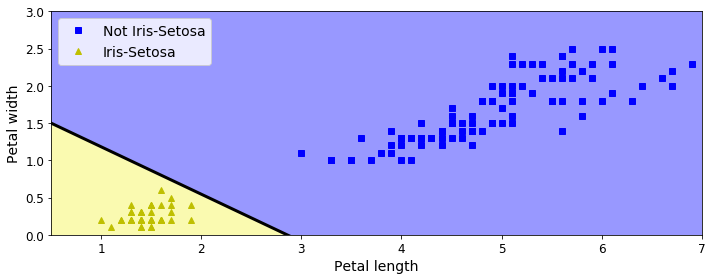

In [6]:
a = -per_clf.coef_[0][0]/ per_clf.coef_[0][1]
b= -per_clf.intercept_/per_clf.coef_[0][1]

axes=[0.5, 7, 0, 3]

x0, x1= np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1,1),
    np.linspace(axes[2], axes[3], 200).reshape(-1,1),
    )

X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz=y_predict.reshape(x0.shape)

plt.figure(figsize=(10,4))
plt.plot(X[y==0,0], X[y==0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y==1,0], X[y==1, 1], 'y^', label='Iris-Setosa')
plt.plot([axes[0], axes[1]], [a*axes[0] +b, a*axes[1]+b], 'k-', linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc = 'upper left', fontsize=14)
plt.axis(axes)

save_fig('perceptron_iris_plot')
plt.show()


##### Activation functions

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def relu(z):
    return np.maximum(0, z)
def derivative(f, z, eps = 0.000001):
    return (f(z+eps)-f(z-eps))/(2*eps)

Saving figure activation_functions_plot


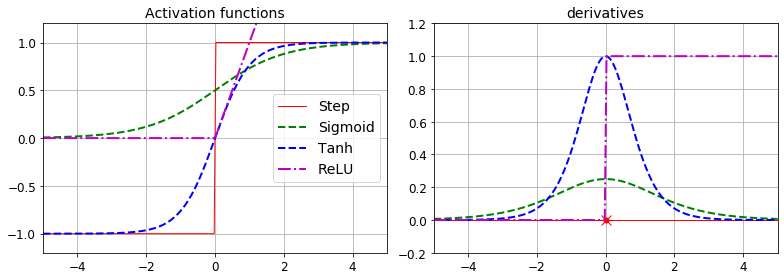

In [8]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b--', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc = 'center right', fontsize=14)
plt.title('Activation functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign,z), 'r-', linewidth=1, label='Step')
plt.plot(0,0, 'ro', markersize=5)
plt.plot(0, 0, 'rx', markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, derivative(np.tanh, z), 'b--', linewidth=2, label='Tanh')
plt.plot(z, derivative(relu,z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.title('derivatives', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig('activation_functions_plot')
plt.show()

In [9]:
def heaviside(z):
    return(z>=0).astype(z.dtype)

def mlp_xor(x, x2, activation = heaviside):
    return activation(-activation(x1 + x2 -1.5) + activation(x1 + x2 -0.5) -0.5)

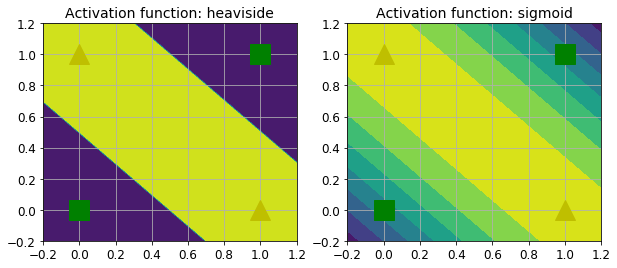

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation = sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0,1], [0,1], 'gs', markersize=20)
plt.plot([0,1], [1,0], 'y^', markersize=20)
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0,1], [0,1], 'gs', markersize=20)
plt.plot([0,1], [1,0], 'y^', markersize=20)
plt.title('Activation function: sigmoid', fontsize=14)
plt.grid(True)


##### Building an Image Classifier

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
#every image is represented by 28X28 array rather than a 1D array of 784
# each pixel intensities are represented as integers( 0 to 255) rther than floats

In [13]:
X_train_full.shape

(60000, 28, 28)

In [14]:
X_train_full.dtype

dtype('uint8')

In [15]:
# creating validation set + scale intensity between 0 & 1 by dividing by 255 - converting to float
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

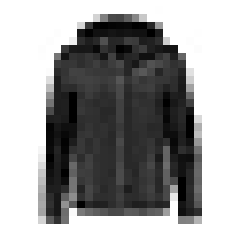

In [16]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()


In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [19]:
class_names[y_train[0]]

'Coat'

In [68]:
X_valid.shape

(5000, 28, 28)

In [69]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


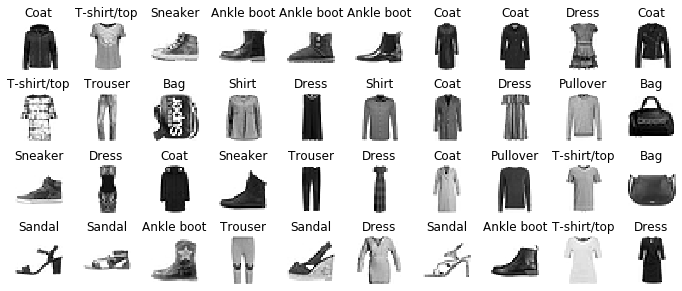

In [70]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

##### Neural network
MLP of two hidden layers

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [34]:
model.layers

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [36]:
keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [37]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [38]:
model.get_layer('dense') is hidden1

True

In [40]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [41]:
weights.shape

(784, 300)

In [42]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
biases.shape

(300,)

In [44]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4393 - accuracy: 0.8454 - val_loss: 0.5330 - val_accuracy: 0.7980
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4125 - accuracy: 0.8569 - val_loss: 0.3915 - val_accuracy: 0.8644
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3940 - accuracy: 0.8619 - val_loss: 0.3748 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3752 - accuracy: 0.8674 - val_loss: 0.3707 - val_accuracy: 0.8722
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3633 - accuracy: 0.8714 - val_loss: 0.3627 - val_accuracy:

In [46]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [47]:
history.history

{'loss': [0.7236780524253845,
  0.4843233525753021,
  0.43925395607948303,
  0.41249433159828186,
  0.39395850896835327,
  0.37522026896476746,
  0.36334460973739624,
  0.35189977288246155,
  0.3415890038013458,
  0.33219200372695923,
  0.32431620359420776,
  0.31506234407424927,
  0.30816128849983215,
  0.3023137152194977,
  0.29484379291534424,
  0.289277583360672,
  0.2841065526008606,
  0.277920126914978,
  0.27297961711883545,
  0.26764771342277527,
  0.26259559392929077,
  0.2577607333660126,
  0.253675252199173,
  0.24865274131298065,
  0.24440625309944153,
  0.24075055122375488,
  0.23647968471050262,
  0.23291146755218506,
  0.22853097319602966,
  0.22528870403766632],
 'accuracy': [0.7644181847572327,
  0.8317636251449585,
  0.8453817963600159,
  0.8568727374076843,
  0.8618909120559692,
  0.8673818111419678,
  0.871399998664856,
  0.875,
  0.8785272836685181,
  0.8825091123580933,
  0.8830181956291199,
  0.8867999911308289,
  0.889018177986145,
  0.8916181921958923,
  0.8939

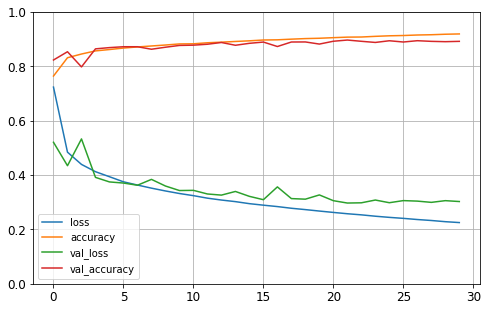

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [50]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3361 - accuracy: 0.8834


[0.3360535800457001, 0.883400022983551]

In [51]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [52]:
y_pred=model.predict_classes(X_new)
y_pred

C:\Users\vinym\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([9, 2, 1], dtype=int64)

In [54]:
y_pred = np.argmax(model.predict(X_new), axis =-1)
y_pred

array([9, 2, 1], dtype=int64)

In [55]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [56]:
y_new=y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


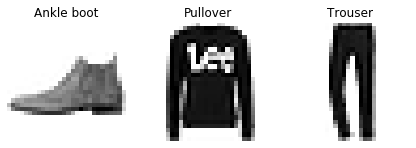

In [58]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1,3, index+1)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
    
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()


##### Regression MLP - with California housing dataset - Sequential API

In [64]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [65]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state =42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state =42)

In [66]:
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test=scaler.transform(X_test)

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)])

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test=model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.8737 - val_loss: 0.7688
Epoch 2/20
363/363 [==============================] - 0s 883us/step - loss: 0.6360 - val_loss: 0.6091
Epoch 3/20
363/363 [==============================] - 0s 814us/step - loss: 0.5649 - val_loss: 0.5705
Epoch 4/20
363/363 [==============================] - 0s 830us/step - loss: 0.5354 - val_loss: 0.5174
Epoch 5/20
363/363 [==============================] - 0s 840us/step - loss: 0.5143 - val_loss: 0.4895
Epoch 6/20
363/363 [==============================] - 0s 820us/step - loss: 0.4965 - val_loss: 0.4710
Epoch 7/20
363/363 [==============================] - 0s 822us/step - loss: 0.4821 - val_loss: 0.4634
Epoch 8/20
363/363 [==============================] - 0s 772us/step - loss: 0.4702 - val_loss: 0.4442
Epoch 9/20
363/363 [==============================] - 0s 966us/step - loss: 0.4602 - val_loss: 0.4338
Epoch 10/20
363/363 [==============================] - 0s 839us/step - loss: 0.4519 

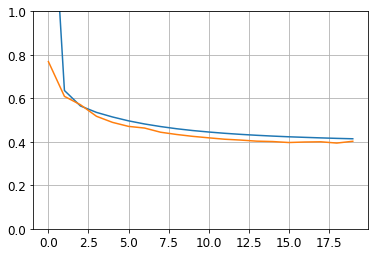

In [73]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [74]:
y_pred

array([[0.58685887],
       [1.7166928 ],
       [3.4294915 ]], dtype=float32)

###### Functional API - Neural network - 3 different architecture
###### See figure 10-14

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat=keras.layers.concatenate([input_, hidden2])
output=keras.layers.Dense(1)(concat)
model=keras.models.Model(inputs=[input_], outputs=[output])

In [81]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 30)           270         input_3[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 30)           930         dense_12[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_3[0][0]                    
                                                                 dense_13[0][0]               

In [86]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test=model.evaluate(X_test, y_test)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3710 - val_loss: 0.3721
Epoch 2/20
363/363 [==============================] - 0s 918us/step - loss: 0.3700 - val_loss: 0.4372
Epoch 3/20
363/363 [==============================] - 0s 930us/step - loss: 0.3692 - val_loss: 0.4056
Epoch 4/20
363/363 [==============================] - 0s 887us/step - loss: 0.3680 - val_loss: 0.3777
Epoch 5/20
363/363 [==============================] - 0s 875us/step - loss: 0.3675 - val_loss: 0.3728
Epoch 6/20
363/363 [==============================] - 0s 921us/step - loss: 0.3663 - val_loss: 0.3962
Epoch 7/20
363/363 [==============================] - 0s 943us/step - loss: 0.3658 - val_loss: 0.3729
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3649 - val_loss: 0.3579
Epoch 9/20
363/363 [==============================] - 0s 942us/step - loss: 0.3640 - val_loss: 0.3884
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3633 - va

In [87]:
y_pred = model.predict(X_new)
y_pred

array([[0.7678968],
       [1.7078471],
       [4.008856 ]], dtype=float32)

###### See figure 10-15: What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [115]:
np.random.seed(42)
tf.random.set_seed(42)

input_a = keras.layers.Input(shape=[5], name='wide_input')
input_b = keras.layers.Input(shape=[6], name='deep_input')
hidden1=keras.layers.Dense(30, activation='relu')(input_b)
hidden2=keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_a, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model2=keras.Model(inputs =[input_a, input_b], outputs=[output])

In [116]:
model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 30)           930         dense_32[0][0]                   
____________________________________________________________________________________________

In [117]:
model2.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B= X_test_A[:3], X_test_B[:3]

history = model2.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data =((X_valid_A, X_valid_B), y_valid))
mse_test = model2.evaluate((X_test_A, X_test_B), y_test)
y_pred = model2.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 993us/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 972us/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 976us/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 967us/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 965us/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 967us/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 973us/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4644 - va

In [118]:
y_pred2 = model2.predict((X_new_a, X_new_b))
y_pred2

array([[0.30591232],
       [1.9540672 ],
       [3.4426107 ]], dtype=float32)

######  See figure 10-16: Adding an auxiliary output for regularization: use case for multiple outputs

In [119]:
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model3 = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [120]:
model3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 30)           930         dense_34[0][0]                   
____________________________________________________________________________________________

In [121]:
model3.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [122]:
history = model3.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

In [123]:
y_pred3 = model3.predict((X_new_a, X_new_b))
y_pred3

[array([[0.26762432],
        [1.980763  ],
        [3.3396285 ]], dtype=float32),
 array([[0.9593649],
        [1.9240992],
        [2.5152812]], dtype=float32)]

###### Subclassing API to build dynamic models with Keras

In [132]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model4 = WideAndDeepModel(30, activation="relu")

In [133]:
model4.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model4.fit([X_train_A, X_train_B], [y_train, y_train], epochs=10, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
total_loss, main_loss, aux_loss = model4.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model4.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 2.4279 - output_1_loss: 2.1375 - output_2_loss: 5.0411 - val_loss: 1.4227 - val_output_1_loss: 1.0831 - val_output_2_loss: 4.4785
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 1.0651 - output_1_loss: 0.8356 - output_2_loss: 3.1305 - val_loss: 1.0173 - val_output_1_loss: 0.7431 - val_output_2_loss: 3.4849
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.8126 - output_1_loss: 0.6751 - output_2_loss: 2.0504 - val_loss: 0.8921 - val_output_1_loss: 0.6684 - val_output_2_loss: 2.9055
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7078 - output_1_loss: 0.6156 - output_2_loss: 1.5381 - val_loss: 0.7912 - val_output_1_loss: 0.6051 - val_output_2_loss: 2.4659
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6509 - output_1_loss: 0.5801 - output_2_loss: 1.2881 - val_loss: 0.7219 - val_output_1_loss: 0.5706 - val_ou

In [134]:
y_pred_main, y_pred_aux

(array([[0.38445035],
        [1.58322   ],
        [2.9508295 ]], dtype=float32),
 array([[1.0679609],
        [1.7726775],
        [2.2040095]], dtype=float32))

###### Saving & restoring

In [136]:
np.random.seed(42)
tf.random.set_seed(42)

model5 = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
    ])

In [139]:
model5.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
history=model5.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test=model5.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 897us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 904us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 870us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 923us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 894us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 984us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 519us/step - loss: 0.4382


In [140]:
model5.save('my_keras_model.h5')

In [141]:
model6 = keras.models.load_model('my_keras_model.h5')

In [142]:
model6.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [143]:
model6.save_weights('my_keras_weights.ckpt')

In [145]:
model6.load_weights('my_keras_weights.ckpt')

###### Using callbacks during training

In [146]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [147]:
model7=keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
    ])

In [148]:
model7.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history=model7.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model8 = keras.models.load_model('my_keras_model.h5') # rollback to best model7
mse_test=model8.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 916us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 892us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 918us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 925us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 591us/step - loss: 0.4382


In [150]:
model8.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history=model8.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
                   callbacks=[checkpoint_cb, early_stopping_cb])
mse_test=model8.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 934us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 969us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 859us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 992us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 773us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 894us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 806us/step - loss: 0

Epoch 80/100
363/363 [==============================] - 0s 729us/step - loss: 0.3329 - val_loss: 0.3353
Epoch 81/100
363/363 [==============================] - 0s 725us/step - loss: 0.3324 - val_loss: 0.3276
Epoch 82/100
363/363 [==============================] - 0s 736us/step - loss: 0.3320 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 0s 760us/step - loss: 0.3317 - val_loss: 0.3281
Epoch 84/100
363/363 [==============================] - 0s 798us/step - loss: 0.3312 - val_loss: 0.3636
Epoch 85/100
363/363 [==============================] - 0s 733us/step - loss: 0.3310 - val_loss: 0.3175
Epoch 86/100
363/363 [==============================] - 0s 725us/step - loss: 0.3308 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 0s 764us/step - loss: 0.3305 - val_loss: 0.3532
Epoch 88/100
363/363 [==============================] - 0s 695us/step - loss: 0.3299 - val_loss: 0.3256
Epoch 89/100
363/363 [==============================] - 0s 742us

In [154]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [155]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history=model8.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid),
                   callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 981us/step - loss: 0.3300 - val_loss: 0.3200

val/train: 0.97


###### TensorBoard

In [156]:
root_logdir=os.path.join(os.curdir, 'my_logs')

In [157]:
def get_run_logdir():
    import time
    run_id= time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir=get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_08_18-08_49_35'

In [158]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [159]:
model9 = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
    ])

In [160]:
model9.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [162]:
tensorboard_cb= keras. callbacks.TensorBoard(run_logdir)
history = model9.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 952us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 959us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 936us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 944us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 969us/step - loss: 0.4474 - val_lo

In [163]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006


In [164]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2021_08_18-12_53_35'

In [166]:
keras.backend. clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [167]:
model10 = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
    ])

In [174]:
model10.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.05))

In [175]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history=model10.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5530 - val_loss: 302.8466
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 63.6669 - val_loss: 0.9735
Epoch 3/30
363/363 [==============================] - 0s 961us/step - loss: 0.9411 - val_loss: 0.9599
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9197 - val_loss: 0.8464
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9819 - val_loss: 0.9281
Epoch 6/30
363/363 [==============================] - 0s 983us/step - loss: 0.9240 - val_loss: 0.9089
Epoch 7/30
363/363 [==============================] - 0s 972us/step - loss: 0.9179 - val_loss: 0.8815
Epoch 8/30
363/363 [==============================] - 0s 982us/step - loss: 0.8950 - val_loss: 0.9007
Epoch 9/30
363/363 [==============================] - 0s 981us/step - loss: 0.9150 - val_loss: 0.8734
Epoch 10/30
363/363 [==============================] - 0s 986us/step - loss: 0.8921 - v

In [176]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [177]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11824), started 0:14:30 ago. (Use '!kill 11824' to kill it.)

###### Hyperparameter Tuning

In [178]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [185]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model11=keras.models.Sequential()
    model11.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model11.add(keras.layers.Dense(n_neurons, activation = 'relu'))
    model11.add(keras.layers.Dense(1))
    optimizer=keras.optimizers.SGD(lr=learning_rate)
    model11.compile(loss='mse', optimizer=optimizer)
    return model11

In [186]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [187]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 984us/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 954us/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 910us/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 936us/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 842us/step - loss: 0.40

In [188]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 607us/step - loss: 0.3412


In [189]:
y_pred11 = keras_reg.predict(X_new)

In [190]:
y_pred11

array([0.6514432, 1.6107497, 4.071351 ], dtype=float32)

In [192]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=65, n_hidden=1, learning_rate=0.003895510903619824 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
242/242 [==============================] - 1s 1ms/step - loss: 1.2461 - val_loss: 25.5377
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9726 - val_loss: 13.1148
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7037 - val_loss: 0.5489
Epoch 4/100
242/242 [==============================] - 0s 991us/step - loss: 0.5162 - val_loss: 0.4882
Epoch 5/100
242/242 [==============================] - 0s 964us/step - loss: 0.4824 - val_loss: 0.4596
Epoch 6/100
242/242 [==============================] - 0s 973us/step - loss: 0.4589 - val_loss: 0.4391
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4435 - val_loss: 0.4181
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4329 - val_loss: 0.4129
Epoch 9/100
242/242 [==============================] - 0s 992us/step - loss: 0.4248 - val_loss: 0.4074
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.418

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


242/242 [==============================] - 1s 2ms/step - loss: 1.1794 - val_loss: 9.5229
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6620 - val_loss: 2.3591
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5693 - val_loss: 0.7709
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5147 - val_loss: 0.4715
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4792 - val_loss: 0.4835
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4720
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4426 - val_loss: 0.4380
Epoch 8/100
242/242 [==============================] - 0s 984us/step - loss: 0.4302 - val_loss: 0.4098
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4202 - val_loss: 0.3986
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4139 - val_loss: 0.4030

242/242 [==============================] - 0s 818us/step - loss: 0.3462 - val_loss: 0.3852
Epoch 60/100
242/242 [==============================] - 0s 806us/step - loss: 0.3491 - val_loss: 0.3380
Epoch 61/100
242/242 [==============================] - 0s 826us/step - loss: 0.3465 - val_loss: 0.3955
Epoch 62/100
242/242 [==============================] - 0s 807us/step - loss: 0.3446 - val_loss: 0.3443
Epoch 63/100
242/242 [==============================] - 0s 830us/step - loss: 0.3445 - val_loss: 0.3244
Epoch 64/100
242/242 [==============================] - 0s 841us/step - loss: 0.3465 - val_loss: 0.3598
Epoch 65/100
242/242 [==============================] - 0s 802us/step - loss: 0.3443 - val_loss: 0.3527
Epoch 66/100
242/242 [==============================] - 0s 820us/step - loss: 0.3432 - val_loss: 0.5167
Epoch 67/100
242/242 [==============================] - 0s 816us/step - loss: 0.3449 - val_loss: 0.4255
Epoch 68/100
242/242 [==============================] - 0s 768us/step - loss:

Epoch 12/100
242/242 [==============================] - 0s 885us/step - loss: 0.4687 - val_loss: 0.4342
Epoch 13/100
242/242 [==============================] - 0s 872us/step - loss: 0.4585 - val_loss: 0.4259
Epoch 14/100
242/242 [==============================] - 0s 924us/step - loss: 0.4498 - val_loss: 0.4199
Epoch 15/100
242/242 [==============================] - 0s 875us/step - loss: 0.4421 - val_loss: 0.4236
Epoch 16/100
242/242 [==============================] - 0s 902us/step - loss: 0.4356 - val_loss: 0.4241
Epoch 17/100
242/242 [==============================] - 0s 898us/step - loss: 0.4294 - val_loss: 0.4148
Epoch 18/100
242/242 [==============================] - 0s 908us/step - loss: 0.4247 - val_loss: 0.4083
Epoch 19/100
242/242 [==============================] - 0s 865us/step - loss: 0.4194 - val_loss: 0.4124
Epoch 20/100
242/242 [==============================] - 0s 907us/step - loss: 0.4154 - val_loss: 0.3992
Epoch 21/100
242/242 [==============================] - 0s 920us

Epoch 17/100
242/242 [==============================] - 0s 773us/step - loss: 0.4782 - val_loss: 0.4536
Epoch 18/100
242/242 [==============================] - 0s 877us/step - loss: 0.4721 - val_loss: 0.4458
Epoch 19/100
242/242 [==============================] - 0s 822us/step - loss: 0.4665 - val_loss: 0.4467
Epoch 20/100
242/242 [==============================] - 0s 853us/step - loss: 0.4619 - val_loss: 0.4427
Epoch 21/100
242/242 [==============================] - 0s 847us/step - loss: 0.4576 - val_loss: 0.4456
Epoch 22/100
242/242 [==============================] - 0s 814us/step - loss: 0.4539 - val_loss: 0.4412
Epoch 23/100
242/242 [==============================] - 0s 886us/step - loss: 0.4506 - val_loss: 0.4410
Epoch 24/100
242/242 [==============================] - 0s 864us/step - loss: 0.4472 - val_loss: 0.4284
Epoch 25/100
242/242 [==============================] - 0s 861us/step - loss: 0.4447 - val_loss: 0.4369
Epoch 26/100
242/242 [==============================] - 0s 787us

242/242 [==============================] - 0s 897us/step - loss: 0.4409 - val_loss: 0.4397
Epoch 22/100
242/242 [==============================] - 0s 905us/step - loss: 0.4392 - val_loss: 0.4167
Epoch 23/100
242/242 [==============================] - 0s 790us/step - loss: 0.4367 - val_loss: 0.4238
Epoch 24/100
242/242 [==============================] - 0s 902us/step - loss: 0.4313 - val_loss: 0.4555
Epoch 25/100
242/242 [==============================] - 0s 965us/step - loss: 0.4305 - val_loss: 0.4154
Epoch 26/100
242/242 [==============================] - 0s 873us/step - loss: 0.4265 - val_loss: 0.4117
Epoch 27/100
242/242 [==============================] - 0s 833us/step - loss: 0.4237 - val_loss: 0.4611
Epoch 28/100
242/242 [==============================] - 0s 881us/step - loss: 0.4238 - val_loss: 0.4167
Epoch 29/100
242/242 [==============================] - 0s 882us/step - loss: 0.4203 - val_loss: 0.7739
Epoch 30/100
242/242 [==============================] - 0s 859us/step - loss:

Epoch 24/100
242/242 [==============================] - 0s 896us/step - loss: 0.4220 - val_loss: 0.3963
Epoch 25/100
242/242 [==============================] - 0s 875us/step - loss: 0.4175 - val_loss: 0.3953
Epoch 26/100
242/242 [==============================] - 0s 874us/step - loss: 0.4130 - val_loss: 0.3924
Epoch 27/100
242/242 [==============================] - 0s 837us/step - loss: 0.4092 - val_loss: 0.3896
Epoch 28/100
242/242 [==============================] - 0s 942us/step - loss: 0.4055 - val_loss: 0.3924
Epoch 29/100
242/242 [==============================] - 0s 880us/step - loss: 0.4021 - val_loss: 0.3893
Epoch 30/100
242/242 [==============================] - 0s 884us/step - loss: 0.3993 - val_loss: 0.3836
Epoch 31/100
242/242 [==============================] - 0s 872us/step - loss: 0.3964 - val_loss: 0.3783
Epoch 32/100
242/242 [==============================] - 0s 858us/step - loss: 0.3939 - val_loss: 0.3776
Epoch 33/100
242/242 [==============================] - 0s 874us

242/242 [==============================] - 0s 898us/step - loss: 0.4026 - val_loss: 0.3862
Epoch 31/100
242/242 [==============================] - 0s 869us/step - loss: 0.4002 - val_loss: 0.3842
Epoch 32/100
242/242 [==============================] - 0s 893us/step - loss: 0.3982 - val_loss: 0.3885
Epoch 33/100
242/242 [==============================] - 0s 857us/step - loss: 0.3964 - val_loss: 0.3944
Epoch 34/100
242/242 [==============================] - 0s 874us/step - loss: 0.3945 - val_loss: 0.4048
Epoch 35/100
242/242 [==============================] - 0s 868us/step - loss: 0.3929 - val_loss: 0.4139
Epoch 36/100
242/242 [==============================] - 0s 896us/step - loss: 0.3913 - val_loss: 0.4097
Epoch 37/100
242/242 [==============================] - 0s 884us/step - loss: 0.3898 - val_loss: 0.4281
Epoch 38/100
242/242 [==============================] - 0s 936us/step - loss: 0.3884 - val_loss: 0.4380
Epoch 39/100
242/242 [==============================] - 0s 885us/step - loss:

242/242 [==============================] - 0s 907us/step - loss: 0.5519 - val_loss: 0.5752
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 1.0721
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5536 - val_loss: 1.4479
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5270 - val_loss: 2.4679
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5674 - val_loss: 0.6705
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5339 - val_loss: 0.5973
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5212 - val_loss: 1.8116
Epoch 14/100
121/121 [==============================] - 0s 701us/step - loss: 0.5408
[CV]  n_neurons=9, n_hidden=0, learning_rate=0.0035153474977444085, total=   6.2s
[CV] n_neurons=9, n_hidden=0, learning_rate=0.0035153474977444085 ....
Epoch 1/100
242/242 [==============================] - 1s 2ms

242/242 [==============================] - 0s 1ms/step - loss: 0.5303 - val_loss: 1.0297
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5410 - val_loss: 0.7255
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5459 - val_loss: 0.7824
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5261 - val_loss: 1.4996
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5550 - val_loss: 0.5147
Epoch 18/100
242/242 [==============================] - 0s 922us/step - loss: 0.5227 - val_loss: 1.6235
Epoch 19/100
242/242 [==============================] - 0s 987us/step - loss: 0.5512 - val_loss: 0.5209
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5268 - val_loss: 1.1727
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5550 - val_loss: 1.4014
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5234 - val_lo

242/242 [==============================] - 0s 1ms/step - loss: 0.5396 - val_loss: 0.8240
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5386 - val_loss: 0.8504
Epoch 20/100
242/242 [==============================] - 0s 931us/step - loss: 0.5380 - val_loss: 0.8374
Epoch 21/100
242/242 [==============================] - 0s 968us/step - loss: 0.5388 - val_loss: 0.6320
Epoch 22/100
121/121 [==============================] - 0s 590us/step - loss: 0.5347
[CV]  n_neurons=84, n_hidden=0, learning_rate=0.001384886175649522, total=   5.7s
[CV] n_neurons=84, n_hidden=0, learning_rate=0.001384886175649522 ....
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 5.1426 - val_loss: 13.1288
Epoch 2/100
242/242 [==============================] - 0s 940us/step - loss: 1.6529 - val_loss: 14.3075
Epoch 3/100
242/242 [==============================] - 0s 868us/step - loss: 0.8714 - val_loss: 15.6450
Epoch 4/100
242/242 [==============================] 

242/242 [==============================] - 0s 770us/step - loss: 0.5578 - val_loss: 0.5255
Epoch 23/100
242/242 [==============================] - 0s 799us/step - loss: 0.5522 - val_loss: 0.5210
Epoch 24/100
242/242 [==============================] - 0s 829us/step - loss: 0.5469 - val_loss: 0.5169
Epoch 25/100
242/242 [==============================] - 0s 807us/step - loss: 0.5420 - val_loss: 0.5096
Epoch 26/100
242/242 [==============================] - 0s 794us/step - loss: 0.5371 - val_loss: 0.5019
Epoch 27/100
242/242 [==============================] - 0s 773us/step - loss: 0.5323 - val_loss: 0.5000
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5281 - val_loss: 0.4928
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5236 - val_loss: 0.4890
Epoch 30/100
242/242 [==============================] - 0s 786us/step - loss: 0.5195 - val_loss: 0.4849
Epoch 31/100
242/242 [==============================] - 0s 789us/step - loss: 0.5

121/121 [==============================] - 0s 493us/step - loss: 0.4154
[CV]  n_neurons=60, n_hidden=1, learning_rate=0.000407717619148505, total=  21.1s
[CV] n_neurons=60, n_hidden=1, learning_rate=0.000407717619148505 ....
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 2.9746 - val_loss: 11.6793
Epoch 2/100
242/242 [==============================] - 0s 853us/step - loss: 1.5661 - val_loss: 14.3838
Epoch 3/100
242/242 [==============================] - 0s 839us/step - loss: 1.0865 - val_loss: 14.6046
Epoch 4/100
242/242 [==============================] - 0s 753us/step - loss: 0.9061 - val_loss: 13.4416
Epoch 5/100
242/242 [==============================] - 0s 830us/step - loss: 0.8234 - val_loss: 11.7722
Epoch 6/100
242/242 [==============================] - 0s 831us/step - loss: 0.7760 - val_loss: 10.1187
Epoch 7/100
242/242 [==============================] - 0s 766us/step - loss: 0.7437 - val_loss: 8.6227
Epoch 8/100
242/242 [=============================

242/242 [==============================] - 0s 831us/step - loss: 0.4723 - val_loss: 0.4475
Epoch 38/100
242/242 [==============================] - 0s 890us/step - loss: 0.4693 - val_loss: 0.4454
Epoch 39/100
242/242 [==============================] - 0s 827us/step - loss: 0.4665 - val_loss: 0.4429
Epoch 40/100
242/242 [==============================] - 0s 888us/step - loss: 0.4638 - val_loss: 0.4405
Epoch 41/100
242/242 [==============================] - 0s 849us/step - loss: 0.4612 - val_loss: 0.4402
Epoch 42/100
242/242 [==============================] - 0s 873us/step - loss: 0.4589 - val_loss: 0.4388
Epoch 43/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4566 - val_loss: 0.4353
Epoch 44/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4545 - val_loss: 0.4343
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4524 - val_loss: 0.4324
Epoch 46/100
242/242 [==============================] - 0s 869us/step - loss: 0.450

242/242 [==============================] - 0s 726us/step - loss: 0.9991 - val_loss: 71.9378
Epoch 8/100
242/242 [==============================] - 0s 798us/step - loss: 1.3957 - val_loss: 117.6742
Epoch 9/100
242/242 [==============================] - 0s 717us/step - loss: 1.8979 - val_loss: 160.9355
Epoch 10/100
242/242 [==============================] - 0s 740us/step - loss: 1.1749 - val_loss: 130.7724
Epoch 11/100
242/242 [==============================] - 0s 761us/step - loss: 3.0708 - val_loss: 141.0030
Epoch 12/100
121/121 [==============================] - 0s 973us/step - loss: 0.5010
[CV]  n_neurons=15, n_hidden=0, learning_rate=0.005554415729949388, total=   2.7s
[CV] n_neurons=42, n_hidden=0, learning_rate=0.002455785301566658 ....
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 3.1705 - val_loss: 1.2371
Epoch 2/100
242/242 [==============================] - 0s 839us/step - loss: 0.9091 - val_loss: 0.7084
Epoch 3/100
242/242 [=======================

242/242 [==============================] - 0s 820us/step - loss: 0.5419 - val_loss: 0.6093
Epoch 15/100
242/242 [==============================] - 0s 805us/step - loss: 0.5438 - val_loss: 0.5298
Epoch 16/100
242/242 [==============================] - 0s 712us/step - loss: 0.5343 - val_loss: 0.9416
Epoch 17/100
242/242 [==============================] - 0s 790us/step - loss: 0.5457 - val_loss: 0.5120
Epoch 18/100
242/242 [==============================] - 0s 803us/step - loss: 0.5375 - val_loss: 0.5010
Epoch 19/100
242/242 [==============================] - 0s 779us/step - loss: 0.5307 - val_loss: 1.0572
Epoch 20/100
242/242 [==============================] - 0s 787us/step - loss: 0.5451 - val_loss: 0.4956
Epoch 21/100
242/242 [==============================] - 0s 787us/step - loss: 0.5346 - val_loss: 0.5485
Epoch 22/100
242/242 [==============================] - 0s 982us/step - loss: 0.5347 - val_loss: 0.5744
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.3min finished


363/363 [==============================] - 1s 1ms/step - loss: 1.9492 - val_loss: 1.9438
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7052 - val_loss: 0.6583
Epoch 3/100
363/363 [==============================] - 0s 809us/step - loss: 0.6343 - val_loss: 0.6086
Epoch 4/100
363/363 [==============================] - 0s 852us/step - loss: 0.5924 - val_loss: 0.5458
Epoch 5/100
363/363 [==============================] - 0s 842us/step - loss: 0.5580 - val_loss: 0.5166
Epoch 6/100
363/363 [==============================] - 0s 969us/step - loss: 0.5281 - val_loss: 0.4838
Epoch 7/100
363/363 [==============================] - 0s 911us/step - loss: 0.5042 - val_loss: 0.4784
Epoch 8/100
363/363 [==============================] - 0s 772us/step - loss: 0.4847 - val_loss: 0.4683
Epoch 9/100
363/363 [==============================] - 0s 787us/step - loss: 0.4668 - val_loss: 0.4281
Epoch 10/100
363/363 [==============================] - 0s 823us/step - loss: 0.4527 - va

363/363 [==============================] - 0s 857us/step - loss: 0.3322 - val_loss: 0.3503
Epoch 81/100
363/363 [==============================] - 0s 873us/step - loss: 0.3317 - val_loss: 0.3371
Epoch 82/100
363/363 [==============================] - 0s 962us/step - loss: 0.3312 - val_loss: 0.3265
Epoch 83/100
363/363 [==============================] - 0s 955us/step - loss: 0.3308 - val_loss: 0.3444


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000027E59FA9E48>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.00037192261022352417,
                                                          0.026584732357599207,
                                                          0.0008763224455697141,
                                                          0.0004553382391952247,
                                                          0.0051747964719537,
                                                          0.0017460040118129545,
                                                          0.027...
                                                          0.009723980412586881,
                                                          0.002125362451575068,
                                                          0.00078

In [193]:
rnd_search_cv.best_params_

{'n_neurons': 82, 'n_hidden': 2, 'learning_rate': 0.0009105229973597177}

In [194]:
rnd_search_cv.best_score_

-0.3779635230700175

In [195]:
rnd_search_cv.best_estimator_

In [196]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 818us/step - loss: 0.3353


-0.3353423476219177

In [198]:
model12 = rnd_search_cv.best_estimator_.model
model12

In [199]:
model12.evaluate(X_test, y_test)

162/162 [==============================] - 0s 719us/step - loss: 0.3353


0.3353423476219177